In [1]:
import torch
from torch.autograd import Variable as V
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

In [2]:
torch.autograd.set_detect_anomaly(False)  # use to detect nans (SLOW!!)

if torch.cuda.is_available():
    device = torch.device("cuda")  # works for ROCm too
    print('cuda devices:', torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f'\t{torch.cuda.get_device_properties(i).name}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = torch.device("cpu")
torch.set_default_device(device)
dtype = torch.float
torch.set_default_dtype(dtype)

In [3]:
class Camera:
    def __init__(self, pos, u, v, w, focal_length, size, render_distance, resolution):
        self.pos = pos.float().to(device)
        # orthonormal basis for camera POV
        self.u = u  # left
        self.v = v  # up
        self.w = w  # forward (viewing direction)
        self.d = focal_length  # distance from pos to pixels
        self.size = size
        self.max_dist = render_distance;
        self.res = resolution

    def pixel_pos(self, i, j):
        width, height = self.res
        w_ratio = width / max(width, height)
        h_ratio = height / max(width, height)
        if i < 0 or j < 0 or i >= width or j >= height:
            raise IndexError('Pixel out of bounds')
        return self.pos + self.d * self.w \
                        + w_ratio * self.size / 2 * (i / width - 0.5) * self.u \
                        + h_ratio * self.size / 2 * (j / height - 0.5) * self.v

    def pixel_dir(self, i, j):
        dir = self.pixel_pos(i, j) - self.pos
        return dir / dir.norm()

    def all_pixel_dirs(self):
        width, height = self.res
        dirs = torch.zeros((width, height, 3), device=device)
        for i in range(width):
            for j in range(height):
                dirs[i, j, :] = self.pixel_dir(i, j)
        return dirs

    def origins(self):
        width, height = self.res
        return torch.tile(self.pos, (width, height, 1)).to(device)


In [52]:
class BlenderDefaultCamera(Camera):
    def __init__(self, pos, u, v, w, res):
        super().__init__(pos, u, v, w, 0.005, 0.036, 50, res)

class BlenderOrbitCamera(BlenderDefaultCamera):
    def __init__(self, pos, res):
        u, v, w = camera_dir_from_pos(pos)
        super().__init__(pos, u, v, w, res)

In [5]:
def camera_dir_from_pos(pos):
    x, y, z = pos
    x_angle = np.pi / 2 - torch.arctan2(z, torch.sqrt(x ** 2 + y ** 2))
    z_angle = np.pi / 2 + torch.arctan2(y, x)
    rotation = R.from_euler('xyz', [x_angle, 0, z_angle])
    M = torch.from_numpy(rotation.as_matrix()).float()
    return (M[:, 0], M[:, 1], M[:, 2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


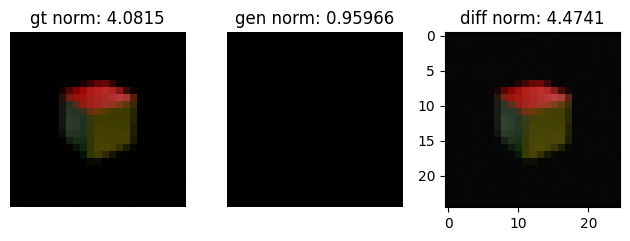

In [146]:
class NeRF(torch.nn.Module):
    def __init__(self, training_dir, res, samples_per_ray, layer_size=128):
        super().__init__()
        self.layer_size = layer_size
        self.d1 = torch.nn.Sequential(
            torch.nn.Linear(3, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU()
        )
        self.d2 = torch.nn.Sequential(
            torch.nn.Linear(layer_size + 3, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, 4)
        )

        self.dir = training_dir
        self.camera_positions = torch.from_numpy(np.genfromtxt(f'{self.dir}/coords.csv', delimiter=',')).float()
        self.res = res
        self.samples_per_ray = samples_per_ray


    def get_camera_for_pos(self, i):
        return BlenderOrbitCamera(self.camera_positions[i, :], self.res)


    def forward(self, x, dir):
        curr = self.d1(x)
        curr = torch.cat((curr, x), dim=2)
        curr = self.d2(curr)
        density = torch.nn.functional.leaky_relu(curr[:, :, 0].unsqueeze(2))
        colour = torch.sigmoid(curr[:, :, 1:])
        return density, colour


    def render(self, camera):
        width, height = self.res
        
        h = camera.max_dist / self.samples_per_ray
        origins = camera.origins()
        dirs = torch.zeros_like(camera.all_pixel_dirs())
        
        density_so_far = torch.zeros((width, height, 1), device=device, requires_grad=True)
        pixels = torch.zeros((width, height, 3), device=device, requires_grad=True)

        prev_t = 0
        for s in torch.arange(0, camera.max_dist, h):
            t = s + torch.rand((1,)) * h
            # t = s
            x = origins + t * dirs

            # HERE -------------------------------
            density, colour = self(x, dirs)
            # HERE -------------------------------

            delta = (t - prev_t)

            
            # print(colour)

            density_so_far = density_so_far + delta * density
            T = torch.exp(-density_so_far)
            alpha = 1 - torch.exp(-delta * density)

            pixels = pixels + T * alpha * colour
            
            prev_t = t

        return pixels.reshape((width, height, 3))

    
    def get_params_norm(self):
        s = 0
        for param in self.parameters():
            s += param.norm().item()
        return s

    
    def get_training_image(self, i):
        return read_image(f'{self.dir}/{i}.png')[:3,:].permute(1, 2, 0).float() / 255


    def render_example(self, i):
        cam = BlenderOrbitCamera(self.camera_positions[i, :], self.res)
        return self.render(cam)


    def view_example(self, i):
        rgb_img_torch = self.render_example(i)
        rgb_img_torch = rgb_img_torch / rgb_img_torch.max()
        # rgb_img_torch = torch.softmax(rgb_img_torch, axis=2)
        # print(rgb_img_torch)
        rgb_img_cpu = rgb_img_torch.cpu().detach().numpy()
        plt.axis('off')
        plt.imshow(rgb_img_cpu)

    
    def plot_example(self, i):
        gt_img = self.get_training_image(i).detach().numpy()
        gen_img = self.render_example(i).detach().numpy()
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.axis('off')
        ax2.axis('off')
        ax1.imshow(gt_img)
        ax1.set_title(f'gt norm: {np.linalg.norm(gt_img):3.5}')
        ax2.imshow(gen_img)
        ax2.set_title(f'gen norm: {np.linalg.norm(gen_img):3.5}')
        ax3.imshow(np.abs(gen_img - gt_img))
        ax3.set_title(f'diff norm: {np.linalg.norm(gen_img - gt_img):3.5}')
        fig.tight_layout()


    def train(self, num_epochs=25, lr=0.001, block_size=None):
        N, _ = self.camera_positions.size()
        if block_size == None:
            block_size = N
        for k in range(num_epochs):
            print(f'\nepoch {k+1:>3}/{num_epochs} ----------------')
            for j in range(N // block_size):
                sum = 0
                self.zero_grad()
                for i in range(j * block_size, min((j + 1) * block_size, N)):
                    gt_img = self.get_training_image(i).to(device)
                    gen_img = self.render_example(i)
                    w, h = self.res
                    loss = (gt_img - gen_img).norm() ** 2 / (w * h) / block_size
                    loss.backward()
                    sum += loss.item()
                for param in self.parameters():
                    param.data -= param.grad * lr
                print(f'\tblock {j+1:>3}/{block_size} loss: {sum}')

    
    def test_loss(self, camera):
        origins = V(camera.origins(), requires_grad=True)
        dirs = V(camera.all_pixel_dirs(), requires_grad=True)
        d = torch.zeros((1,), device=device)

        print(origins.is_leaf, dirs.is_leaf, d.is_leaf) # True True True
        
        density, colour = self(origins, dirs)
        self.zero_grad()
        colour[0, 0, 0].backward(retain_graph=True)
        c = 0
        for name, p in self.named_parameters():
            print(f'{c:>3} {name:>10}', end='')
            print(f'\t grad: {p.grad.norm():>2.5}\t{p.requires_grad}')
            c += 1


rrr = 25
spr = 100
model = NeRF(f'./cube_{rrr}x{rrr}', (rrr, rrr), spr)
# model.test_loss(model.get_camera_for_pos(0))
model.plot_example(1)

In [147]:
model.train(lr=10, block_size=10, num_epochs=5)


epoch   0/5 ----------------
	block   0/10 loss: 0.3637918676249683
	block   1/10 loss: 0.40239417366683483
	block   2/10 loss: 0.30227793427184224
	block   3/10 loss: 0.34539743792265654
	block   4/10 loss: 0.37543811835348606
	block   5/10 loss: 0.24737837247084826
	block   6/10 loss: 0.27932992158457637
	block   7/10 loss: 0.3411888387054205
	block   8/10 loss: 0.36023450805805624
	block   9/10 loss: 0.2717590043321252

epoch   1/5 ----------------
	block   0/10 loss: 0.30412717489525676
	block   1/10 loss: 0.37131992261856794
	block   2/10 loss: 0.3045863523148
	block   3/10 loss: 0.3426495175808668
	block   4/10 loss: 0.36521088890731335
	block   5/10 loss: 0.2395556824048981
	block   6/10 loss: 0.256462061079219
	block   7/10 loss: 0.3276019040495157
	block   8/10 loss: 0.34362421673722565
	block   9/10 loss: 0.2615473987534642

epoch   2/5 ----------------
	block   0/10 loss: 0.2937945118173957
	block   1/10 loss: 0.35540164913982153
	block   2/10 loss: 0.29280979838222265
	blo

In [149]:
model.train(lr=1, block_size=20, num_epochs=10)
e = model.render_example(7).detach().numpy()
plt.imshow(e / e.max())
e


epoch   0/10 ----------------
	block   0/20 loss: 0.6303765918128192
	block   1/20 loss: 0.611873391084373
	block   2/20 loss: 0.5884152573999017
	block   3/20 loss: 0.5670496863313019
	block   4/20 loss: 0.5819121450185776

epoch   1/10 ----------------
	block   0/20 loss: 0.6203873932827264
	block   1/20 loss: 0.6097414311952889
	block   2/20 loss: 0.5925455593969673
	block   3/20 loss: 0.5634969086386263
	block   4/20 loss: 0.5816297610290349

epoch   2/10 ----------------
	block   0/20 loss: 0.6206220739986748
	block   1/20 loss: 0.6076545249670744
	block   2/20 loss: 0.5795583184808493
	block   3/20 loss: 0.558056594338268
	block   4/20 loss: 0.5763383065350354

epoch   3/10 ----------------
	block   0/20 loss: 0.6262739771045744
	block   1/20 loss: 0.6010319143533707
	block   2/20 loss: 0.586059267167002
	block   3/20 loss: 0.5610043564811349
	block   4/20 loss: 0.578491038409993

epoch   4/10 ----------------
	block   0/20 loss: 0.6232735686935484
	block   1/20 loss: 0.60933819

KeyboardInterrupt: 

In [ ]:
print(model.layer_size)
model.train(num_epochs=10, lr=1)
e = model.render_example(7).detach().numpy()
plt.imshow(e / e.max())
e

128

epoch   0/10 ----------------


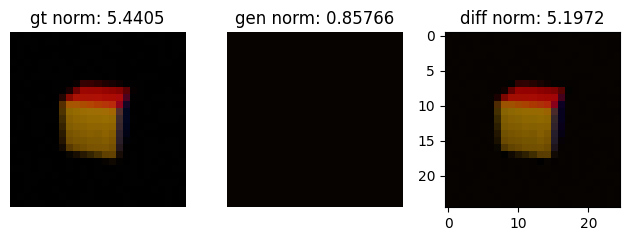

In [132]:
model.plot_example(3)

array([[[0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        ...,
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669]],

       [[0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        ...,
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669]],

       [[0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        ...,
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669]],

       ...,

       [[0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0.01243936, 0.00606669],
        [0.02643433, 0

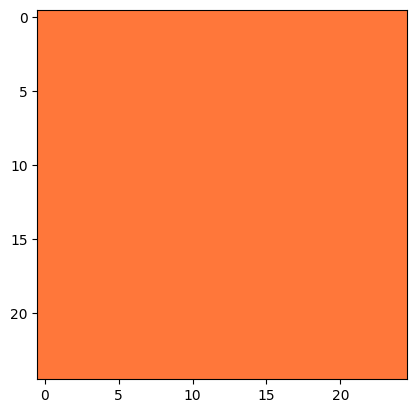

In [135]:
e = model.render_example(7).detach().numpy()
plt.imshow(e / e.max())
e

In [134]:
for name, p in model.named_parameters():
    print(f'{name}: {p}')

d1.0.weight: Parameter containing:
tensor([[ 0.0672, -0.4538,  0.5102],
        [ 0.5598,  0.2165,  0.4924],
        [-0.4282, -0.1277, -0.4664],
        [-0.0458,  0.0631, -0.3108],
        [ 0.4709, -0.3257, -0.3341],
        [ 0.0413,  0.2478, -0.5452],
        [-0.4319, -0.3989,  0.2374],
        [ 0.5460,  0.0342,  0.5341],
        [ 0.1459,  0.0552, -0.1786],
        [ 0.3602, -0.0809,  0.3655],
        [ 0.2098, -0.0189, -0.1938],
        [ 0.0665, -0.4184,  0.2194],
        [ 0.2887, -0.0727, -0.1900],
        [-0.4278, -0.0132,  0.3861],
        [ 0.1154, -0.4990,  0.1184],
        [-0.4351,  0.2646, -0.5162],
        [ 0.3835,  0.3535, -0.5753],
        [ 0.0111, -0.1584,  0.2003],
        [ 0.2479, -0.4377,  0.2364],
        [ 0.0367,  0.4545,  0.1530],
        [ 0.2586, -0.2778,  0.1522],
        [ 0.5376,  0.2923, -0.0506],
        [ 0.5467,  0.1126, -0.1129],
        [-0.5045, -0.2456,  0.1806],
        [-0.1629, -0.5769, -0.4392],
        [ 0.1198, -0.2000,  0.3096],
   

In [142]:
i = 0
cam = BlenderOrbitCamera(model.camera_positions[i, :], model.res)
cam.all_pixel_dirs()

tensor([[[ 0.6965, -0.2948, -0.6542],
         [ 0.7204, -0.3055, -0.6226],
         [ 0.7447, -0.3164, -0.5877],
         ...,
         [ 0.7597, -0.3344,  0.5576],
         [ 0.7347, -0.3240,  0.5960],
         [ 0.7099, -0.3136,  0.6307]],

        [[ 0.6877, -0.2619, -0.6771],
         [ 0.7131, -0.2722, -0.6461],
         [ 0.7391, -0.2826, -0.6115],
         ...,
         [ 0.7557, -0.3008,  0.5818],
         [ 0.7287, -0.2906,  0.6201],
         [ 0.7021, -0.2806,  0.6544]],

        [[ 0.6769, -0.2262, -0.7004],
         [ 0.7038, -0.2358, -0.6701],
         [ 0.7316, -0.2456, -0.6360],
         ...,
         [ 0.7497, -0.2635,  0.6070],
         [ 0.7208, -0.2539,  0.6450],
         [ 0.6925, -0.2445,  0.6787]],

        ...,

        [[-0.0103,  0.6900, -0.7238],
         [-0.0113,  0.7195, -0.6944],
         [-0.0123,  0.7502, -0.6611],
         ...,
         [-0.0240,  0.7738,  0.6330],
         [-0.0235,  0.7416,  0.6704],
         [-0.0231,  0.7105,  0.7034]],

        [[